In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.simplefilter('ignore')
import math
from statistics import mean
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
from sklearn.metrics import mean_squared_error


#from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split
import category_encoders as ce

In [2]:
status = pd.read_csv('../../../status.csv')

In [3]:
#statusのyear, month, dayを結合してdatetime型に
status['date'] = status['year'].astype(str) + '/' + status['month'].astype(str).str.zfill(2).astype(str) + '/' + status['day'].astype(str).str.zfill(2).astype(str) + '/' + status['hour'].astype(str).str.zfill(2).astype(str)
status['date'] = pd.to_datetime(status['date'], format='%Y/%m/%d/%H', infer_datetime_format=True)

#曜日を追加するための関数を定義
def get_weekday_jp(dt):
    w_list = ['月曜日', '火曜日', '水曜日', '木曜日', '金曜日', '土曜日', '日曜日']
    return(w_list[dt.weekday()])

#dateから曜日情報を取得
status["weekday"] = status["date"].apply(get_weekday_jp)

main_df = status[['date','hour', 'station_id', 'bikes_available', 'weekday', 'predict']]

#カテゴリ変数をダミー変数化
main_df = pd.get_dummies(main_df)

train = main_df[main_df['date'] >= '2013-09-30']
train = train[train['date'] < '2013-11-01']
train = train[train['station_id'] == 0] 

test = main_df[main_df['date'] >= '2013-10-31']
test = test[test['date'] < '2013-11-08']
test = test[test['station_id'] == 0] 

#predictは特徴量として必要ないため、削除
train = train.drop("predict",axis=1)
train_df = train 
train

,date,hour,station_id,bikes_available,weekday_土曜日,weekday_日曜日,weekday_月曜日,weekday_木曜日,weekday_水曜日,weekday_火曜日,weekday_金曜日
696,2013-09-30 00:00:00,0,0,18.0,0,0,1,0,0,0,0
697,2013-09-30 01:00:00,1,0,18.0,0,0,1,0,0,0,0
698,2013-09-30 02:00:00,2,0,17.0,0,0,1,0,0,0,0
699,2013-09-30 03:00:00,3,0,17.0,0,0,1,0,0,0,0
700,2013-09-30 04:00:00,4,0,17.0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
1459,2013-10-31 19:00:00,19,0,19.0,0,0,0,1,0,0,0
1460,2013-10-31 20:00:00,20,0,18.0,0,0,0,1,0,0,0
1461,2013-10-31 21:00:00,21,0,18.0,0,0,0,1,0,0,0
1462,2013-10-31 22:00:00,22,0,18.0,0,0,0,1,0,0,0


In [4]:
#今回LSTMモデルを使用するため、データを標準化
#特徴量を標準化するための変数
scaler = MinMaxScaler(feature_range=(0, 1))
#標準化された出力をもとにスケールに変換(inverse)するために必要な変数
scaler_for_inverse = MinMaxScaler(feature_range=(0, 1))

#0から1の範囲に値を正規化して配列に直しているのが下の3行
train_df_scale = scaler.fit_transform(train.iloc[:,3:])
bikes_available_scale = scaler_for_inverse.fit_transform(train[["bikes_available"]])
print(train_df_scale.shape)

(768, 8)


In [5]:
length = len(train_df_scale)
train = train_df_scale[0:length,:]
train

array([[0.73684211, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.73684211, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.68421053, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.73684211, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.73684211, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.68421053, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [6]:
def create_dataset(dataset):
    dataX = []
    dataY = np.array([])
    
    #trainまたはtestの行を計算している。
    max_len = len(dataset)
    for i in range(24,max_len):
        xset = []
        #trainまたはtestの列を繰り返しに入れている。
        for j in range(1, dataset.shape[1]):
            a = dataset[i-24:i, j]
            xset.append(a)
        #各行の正規化したバイク台数を取ってくる
        temp_array = np.array(dataset[i:i+1,0])
        #各行からバイク台数だけを取ってきたものをまとめている
        dataY = np.concatenate([dataY,temp_array])
        dataX.append(xset)
        #dataYの形を変えてるだけ
    dataY = dataY.reshape(-1,1)
    return np.array(dataX), dataY 

In [7]:
trainX, trainY = create_dataset(train)

In [8]:
trainX.shape

(744, 7, 24)

In [9]:
trainY.shape

(744, 1)

In [10]:
#LSTMのモデルに入力用にデータの形を整形
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], trainX.shape[2]))
#入力データと正解データの形を確認
print(trainX.shape)
print(trainY.shape)

(744, 7, 24)
(744, 1)


In [11]:
model = Sequential()
model.add(LSTM(50, input_shape=(trainX.shape[1],24)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50)                15000     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 15,051
Trainable params: 15,051
Non-trainable params: 0
_________________________________________________________________


In [12]:
hist = model.fit(trainX, trainY, epochs=300, batch_size=5, verbose=2)

Epoch 1/300
149/149 - 1s - loss: 0.0401
Epoch 2/300
149/149 - 0s - loss: 0.0231
Epoch 3/300
149/149 - 0s - loss: 0.0221
Epoch 4/300
149/149 - 0s - loss: 0.0208
Epoch 5/300
149/149 - 0s - loss: 0.0196
Epoch 6/300
149/149 - 0s - loss: 0.0209
Epoch 7/300
149/149 - 0s - loss: 0.0199
Epoch 8/300
149/149 - 0s - loss: 0.0198
Epoch 9/300
149/149 - 0s - loss: 0.0191
Epoch 10/300
149/149 - 0s - loss: 0.0192
Epoch 11/300
149/149 - 0s - loss: 0.0194
Epoch 12/300
149/149 - 0s - loss: 0.0188
Epoch 13/300
149/149 - 0s - loss: 0.0188
Epoch 14/300
149/149 - 0s - loss: 0.0196
Epoch 15/300
149/149 - 0s - loss: 0.0194
Epoch 16/300
149/149 - 0s - loss: 0.0193
Epoch 17/300
149/149 - 0s - loss: 0.0187
Epoch 18/300
149/149 - 0s - loss: 0.0186
Epoch 19/300
149/149 - 0s - loss: 0.0188
Epoch 20/300
149/149 - 0s - loss: 0.0189
Epoch 21/300
149/149 - 0s - loss: 0.0187
Epoch 22/300
149/149 - 0s - loss: 0.0183
Epoch 23/300
149/149 - 0s - loss: 0.0182
Epoch 24/300
149/149 - 0s - loss: 0.0185
Epoch 25/300
149/149 - 0s

Epoch 199/300
149/149 - 0s - loss: 0.0172
Epoch 200/300
149/149 - 0s - loss: 0.0170
Epoch 201/300
149/149 - 0s - loss: 0.0172
Epoch 202/300
149/149 - 0s - loss: 0.0170
Epoch 203/300
149/149 - 0s - loss: 0.0170
Epoch 204/300
149/149 - 0s - loss: 0.0171
Epoch 205/300
149/149 - 0s - loss: 0.0170
Epoch 206/300
149/149 - 0s - loss: 0.0171
Epoch 207/300
149/149 - 0s - loss: 0.0170
Epoch 208/300
149/149 - 0s - loss: 0.0171
Epoch 209/300
149/149 - 0s - loss: 0.0170
Epoch 210/300
149/149 - 0s - loss: 0.0171
Epoch 211/300
149/149 - 0s - loss: 0.0171
Epoch 212/300
149/149 - 0s - loss: 0.0171
Epoch 213/300
149/149 - 0s - loss: 0.0171
Epoch 214/300
149/149 - 0s - loss: 0.0171
Epoch 215/300
149/149 - 0s - loss: 0.0170
Epoch 216/300
149/149 - 0s - loss: 0.0169
Epoch 217/300
149/149 - 0s - loss: 0.0170
Epoch 218/300
149/149 - 0s - loss: 0.0172
Epoch 219/300
149/149 - 0s - loss: 0.0171
Epoch 220/300
149/149 - 0s - loss: 0.0171
Epoch 221/300
149/149 - 0s - loss: 0.0169
Epoch 222/300
149/149 - 0s - loss:

In [13]:
#学習済みモデルで予測
train_predict = model.predict(trainX)
#test_predict = model.predict(testX)

#スケールをもとに戻す
train_predict = scaler_for_inverse.inverse_transform(train_predict)
trainY = scaler_for_inverse.inverse_transform(trainY)
#test_predict = scaler_for_inverse.inverse_transform(test_predict)
#testY = scaler_for_inverse.inverse_transform(testY)

#各ステーションのスコアの平均値を算出
train_score_list = []
#test_score_list = []

trainscore = math.sqrt(mean_squared_error(trainY[:,0], train_predict[:,0]))
train_score_list.append(trainscore)
#    testscore = math.sqrt(mean_squared_error(testY[:,i], test_predict[:,i]))
#    test_score_list.append(testscore)
    
print("trainのRMSE平均 : ",mean(train_score_list))
#print("testのRMSE平均 : ",mean(test_score_list))

trainのRMSE平均 :  2.4425794896673647


In [14]:
array = []
for i in train_predict:
    array.append(i[0])
array

[18.507572,
 17.756746,
 17.673084,
 17.692984,
 17.743063,
 17.915205,
 19.157604,
 19.342512,
 17.500267,
 13.906263,
 13.113373,
 12.47049,
 12.556612,
 12.434472,
 12.356585,
 12.380264,
 12.335665,
 14.637642,
 17.293703,
 16.525227,
 15.602368,
 15.597662,
 15.606931,
 15.282244,
 14.973622,
 14.998814,
 14.965614,
 15.02789,
 15.07645,
 15.265641,
 15.881372,
 15.923907,
 13.653213,
 10.246817,
 9.0102,
 11.5528555,
 11.394379,
 11.131703,
 11.622525,
 11.934393,
 12.118697,
 15.676091,
 17.307318,
 16.635778,
 16.11319,
 17.784647,
 18.445251,
 18.623032,
 18.531761,
 18.419447,
 18.392836,
 18.455997,
 18.599873,
 18.860796,
 19.890673,
 20.338583,
 18.562737,
 15.425894,
 14.885357,
 12.905376,
 13.4362135,
 13.500074,
 13.50621,
 13.620059,
 13.623766,
 17.508898,
 19.444279,
 19.054058,
 18.441683,
 17.943935,
 18.004768,
 17.166702,
 17.350475,
 16.870396,
 16.447567,
 16.411148,
 16.373585,
 16.446318,
 17.361797,
 17.603148,
 15.997168,
 11.272768,
 10.626189,
 11.598431

In [15]:
array_bike = []
for i in trainY:
    array_bike.append(i[0])
array_bike

[16.0,
 14.0,
 14.0,
 14.0,
 14.0,
 14.0,
 15.000000000000002,
 16.0,
 15.000000000000002,
 11.000000000000002,
 9.0,
 9.0,
 9.0,
 9.0,
 9.0,
 9.0,
 9.0,
 14.0,
 17.0,
 16.0,
 15.000000000000002,
 15.000000000000002,
 15.000000000000002,
 16.0,
 15.000000000000002,
 15.000000000000002,
 15.000000000000002,
 15.000000000000002,
 15.000000000000002,
 15.000000000000002,
 15.000000000000002,
 15.000000000000002,
 12.0,
 9.0,
 5.0,
 14.0,
 14.0,
 15.000000000000002,
 15.000000000000002,
 15.000000000000002,
 15.000000000000002,
 17.0,
 21.0,
 18.0,
 18.0,
 18.0,
 19.0,
 19.0,
 19.0,
 19.0,
 18.0,
 19.0,
 19.0,
 19.0,
 19.0,
 20.0,
 16.0,
 12.999999999999998,
 12.0,
 10.0,
 12.999999999999998,
 12.999999999999998,
 12.999999999999998,
 12.999999999999998,
 12.999999999999998,
 17.0,
 18.0,
 17.0,
 17.0,
 15.000000000000002,
 15.000000000000002,
 15.000000000000002,
 15.000000000000002,
 14.0,
 14.0,
 14.0,
 14.0,
 14.0,
 14.0,
 15.000000000000002,
 12.999999999999998,
 7.0,
 6.0,
 10.0,
 10

In [16]:
train_visualization_lightgbm = status[status['date'] >= '2013-10-01']
train_visualization_lightgbm = train_visualization_lightgbm[train_visualization_lightgbm['date'] < '2013-11-01']
train_visualization_lightgbm = train_visualization_lightgbm[train_visualization_lightgbm['station_id'] == 0] 

train_visualization_lightgbm['lstm_predict'] = array

train_visualization_lightgbm['date_hour'] = train_visualization_lightgbm['year'].astype(str) + '/' + train_visualization_lightgbm['month'].astype(str).str.zfill(2).astype(str) + '/' + train_visualization_lightgbm['day'].astype(str).str.zfill(2).astype(str) + '/' + train_visualization_lightgbm['hour'].astype(str).str.zfill(2).astype(str)
train_visualization_lightgbm['date_hour'] = pd.to_datetime(train_visualization_lightgbm['date_hour'], format='%Y/%m/%d/%H', infer_datetime_format=True)

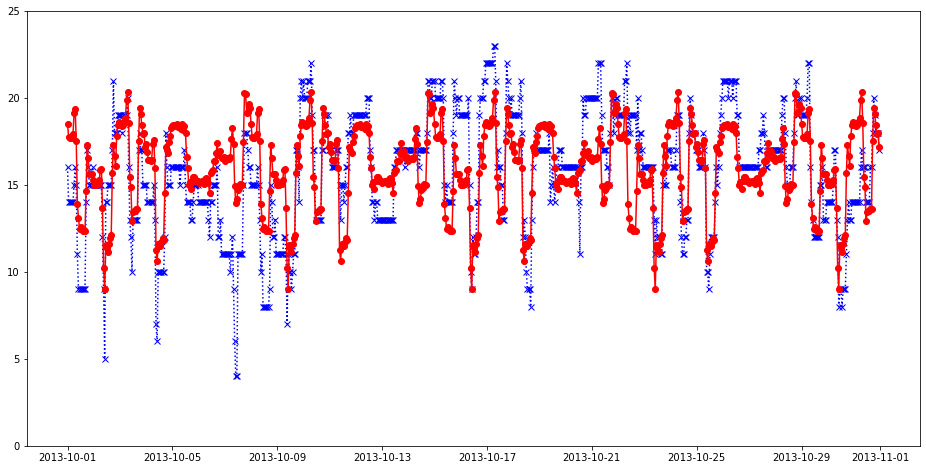

In [17]:
plt.figure(figsize=(16,8))
plt.ylim(0, 25)
plt.plot(train_visualization_lightgbm['date_hour'], train_visualization_lightgbm['bikes_available'], color = 'blue', marker = 'x', linestyle = ':', label = 'predict')
plt.plot(train_visualization_lightgbm['date_hour'], train_visualization_lightgbm['lstm_predict'].values, color = 'red', marker = 'o', linestyle = '-', label = 'answer')

In [18]:
#predictは特徴量として必要ないため、削除
test = test.drop("predict",axis=1)
test

,date,hour,station_id,bikes_available,weekday_土曜日,weekday_日曜日,weekday_月曜日,weekday_木曜日,weekday_水曜日,weekday_火曜日,weekday_金曜日
1440,2013-10-31 00:00:00,0,0,14.0,0,0,0,1,0,0,0
1441,2013-10-31 01:00:00,1,0,14.0,0,0,0,1,0,0,0
1442,2013-10-31 02:00:00,2,0,14.0,0,0,0,1,0,0,0
1443,2013-10-31 03:00:00,3,0,14.0,0,0,0,1,0,0,0
1444,2013-10-31 04:00:00,4,0,14.0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
1627,2013-11-07 19:00:00,19,0,18.0,0,0,0,1,0,0,0
1628,2013-11-07 20:00:00,20,0,16.0,0,0,0,1,0,0,0
1629,2013-11-07 21:00:00,21,0,16.0,0,0,0,1,0,0,0
1630,2013-11-07 22:00:00,22,0,16.0,0,0,0,1,0,0,0


In [19]:
#今回LSTMモデルを使用するため、データを標準化
#特徴量を標準化するための変数
scaler = MinMaxScaler(feature_range=(0, 1))
#標準化された出力をもとにスケールに変換(inverse)するために必要な変数
scaler_for_inverse = MinMaxScaler(feature_range=(0, 1))
test_df_scale = scaler.fit_transform(test.iloc[:,3:])
bikes_available_scale = scaler_for_inverse.fit_transform(test[["bikes_available"]])
print(test_df_scale.shape)

(192, 8)


In [20]:
length = len(test_df_scale)
test = test_df_scale[0:length,:]
print(test.shape)

(192, 8)


In [21]:
testX, testY = create_dataset(test)

In [22]:
#LSTMのモデルに入力用にデータの形を整形
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], testX.shape[2]))
#入力データと正解データの形を確認
print(testX.shape)
print(testY.shape)

(168, 7, 24)
(168, 1)


In [23]:
#学習済みモデルで予測
#train_predict = model.predict(trainX)
test_predict = model.predict(testX)

#スケールをもとに戻す
#train_predict = scaler_for_inverse.inverse_transform(train_predict)
#trainY = scaler_for_inverse.inverse_transform(trainY)
test_predict = scaler_for_inverse.inverse_transform(test_predict)
testY = scaler_for_inverse.inverse_transform(testY)

#各ステーションのスコアの平均値を算出
#train_score_list = []
test_score_list = []

#trainscore = math.sqrt(mean_squared_error(trainY[:,0], train_predict[:,0]))
#train_score_list.append(trainscore)
testscore = math.sqrt(mean_squared_error(testY[:,0], test_predict[:,0]))
test_score_list.append(testscore)
    
#print("trainのRMSE平均 : ",mean(train_score_list))
print("testのRMSE平均 : ",mean(test_score_list))

testのRMSE平均 :  3.88602506210815


In [24]:
array_true = []
for i in testY:
    array_true.append(i[0])
array_true

[17.0,
 16.0,
 16.0,
 16.0,
 16.0,
 16.0,
 16.0,
 17.0,
 15.0,
 13.0,
 11.0,
 11.0,
 12.000000000000002,
 12.000000000000002,
 11.0,
 11.0,
 12.000000000000002,
 16.0,
 16.0,
 16.0,
 16.0,
 19.0,
 19.0,
 19.0,
 19.0,
 19.0,
 19.0,
 19.0,
 18.0,
 19.0,
 19.0,
 19.0,
 19.0,
 19.0,
 18.0,
 18.0,
 18.0,
 18.0,
 16.0,
 16.0,
 16.0,
 15.0,
 16.0,
 16.0,
 16.0,
 16.0,
 15.0,
 16.0,
 16.0,
 17.0,
 0.0,
 17.0,
 17.0,
 17.0,
 16.0,
 16.0,
 17.0,
 17.0,
 17.0,
 18.0,
 18.0,
 18.0,
 18.0,
 18.0,
 18.0,
 18.0,
 16.0,
 17.0,
 17.0,
 17.0,
 17.0,
 16.0,
 16.0,
 16.0,
 16.0,
 16.0,
 16.0,
 16.0,
 17.0,
 19.0,
 16.0,
 13.0,
 12.000000000000002,
 11.0,
 11.0,
 11.0,
 10.0,
 10.0,
 11.0,
 14.0,
 15.0,
 15.0,
 13.0,
 13.0,
 14.0,
 14.0,
 13.0,
 13.0,
 13.0,
 13.0,
 13.0,
 14.0,
 15.0,
 15.0,
 13.0,
 9.0,
 9.0,
 6.000000000000001,
 6.000000000000001,
 6.000000000000001,
 5.0,
 6.000000000000001,
 6.000000000000001,
 9.0,
 11.0,
 12.000000000000002,
 10.0,
 9.0,
 9.0,
 8.0,
 8.0,
 8.0,
 8.0,
 8.0,
 8.0,
 8.

In [25]:
array_pred = []
for i in test_predict:
    array_pred.append(i[0])
array_pred

[14.053133,
 13.547785,
 13.102703,
 13.064367,
 13.024827,
 13.101387,
 14.065051,
 14.319103,
 12.628598,
 7.655545,
 6.9749365,
 7.998348,
 8.021926,
 7.884867,
 8.146934,
 8.358699,
 8.245259,
 11.068729,
 13.862866,
 13.688197,
 13.485443,
 14.165409,
 14.558134,
 15.038304,
 15.137779,
 15.212833,
 15.222179,
 15.132601,
 15.262863,
 15.063065,
 15.124483,
 15.053322,
 14.976465,
 15.245914,
 14.910636,
 15.161888,
 14.702573,
 13.291646,
 12.586966,
 11.5965605,
 11.778573,
 11.310798,
 11.815493,
 12.032814,
 12.071268,
 11.809669,
 11.872951,
 11.833954,
 11.7022915,
 11.724369,
 11.771231,
 11.796701,
 11.727385,
 11.651358,
 11.927303,
 11.98386,
 11.911603,
 11.69991,
 11.106797,
 12.270012,
 12.391832,
 12.480688,
 13.046002,
 13.014708,
 13.509396,
 14.113724,
 13.37022,
 13.541754,
 13.603921,
 13.194361,
 13.185983,
 13.246592,
 13.039893,
 13.145044,
 13.139849,
 13.201162,
 13.17306,
 13.2778845,
 14.343977,
 15.006283,
 14.03182,
 11.525836,
 10.477313,
 10.741207,
 

In [26]:
#2014/09/01以前をtrain、以後をtestに分割(testはpredict = 1のものに絞る)
test_visualization_lightgbm = status[status['date'] >= '2013-11-01']
test_visualization_lightgbm = test_visualization_lightgbm[test_visualization_lightgbm['date'] < '2013-11-08']
test_visualization_lightgbm = test_visualization_lightgbm[test_visualization_lightgbm['station_id'] == 0] 

test_visualization_lightgbm['lstm_predict'] = array_pred

test_visualization_lightgbm['date_hour'] = test_visualization_lightgbm['year'].astype(str) + '/' + test_visualization_lightgbm['month'].astype(str).str.zfill(2).astype(str) + '/' + test_visualization_lightgbm['day'].astype(str).str.zfill(2).astype(str) + '/' + test_visualization_lightgbm['hour'].astype(str).str.zfill(2).astype(str)
test_visualization_lightgbm['date_hour'] = pd.to_datetime(test_visualization_lightgbm['date_hour'], format='%Y/%m/%d/%H', infer_datetime_format=True)

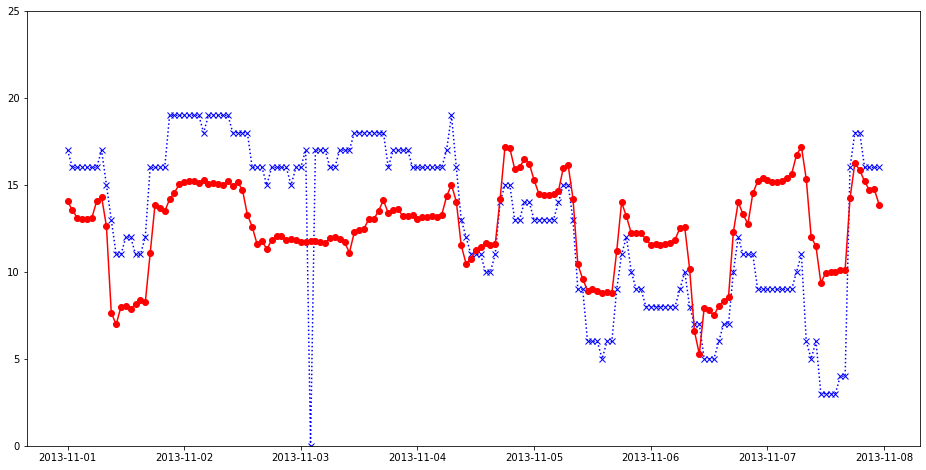

In [27]:
plt.figure(figsize=(16,8))
plt.ylim(0, 25)
plt.plot(test_visualization_lightgbm['date_hour'], test_visualization_lightgbm['bikes_available'], color = 'blue', marker = 'x', linestyle = ':', label = 'predict')
plt.plot(test_visualization_lightgbm['date_hour'], test_visualization_lightgbm['lstm_predict'].values, color = 'red', marker = 'o', linestyle = '-', label = 'answer')